In [1]:
pip install astroquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 22.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import astropy.units as u
import astropy.constants as c

from astropy.coordinates import SkyCoord
from astropy.time import Time

import pandas as pd                          # I/O of data in table format
from astroquery.jplhorizons import Horizons  # python interface to HORIZONS

from tqdm.autonotebook import tqdm as tqdm

from scipy.interpolate import interp1d



<ipython-input-2-275bc0ccd84c>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as tqdm


In [3]:
data_path = './'
scw_file = 'ScwDB_reduced_0016-2704.fits'# Housekeeping file, containing all the data that we need from Integral.


In [4]:
#Getting the info from the file
scw = fits.open(data_path+scw_file)
scw.info()

Filename: ./ScwDB_reduced_0016-2704.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     76   194801R x 26C   [12A, 1I, 1I, 1I, 1I, 20A, 20A, 4I, 4I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 4D, 1D]   


In [5]:
# looking into the pointing distribution:
ra_sc = scw[1].data['RA_SCX']
dec_sc = scw[1].data['DEC_SCX']
# creating coordinate objects for each of the observations
coords_sc = SkyCoord(ra=ra_sc,dec=dec_sc,unit='deg')

# converting the coordinates from ra/dec to Galactic longitude/latitude:
lon_sc = coords_sc.galactic.l.value
# converting from 0..360 to -180..180
lon_sc[lon_sc > 180] -= 360
lat_sc = coords_sc.galactic.b.value
revs = scw[1].data['OrbitRevFrac']
revs_unit = scw[1].columns['OrbitRevFrac'].unit

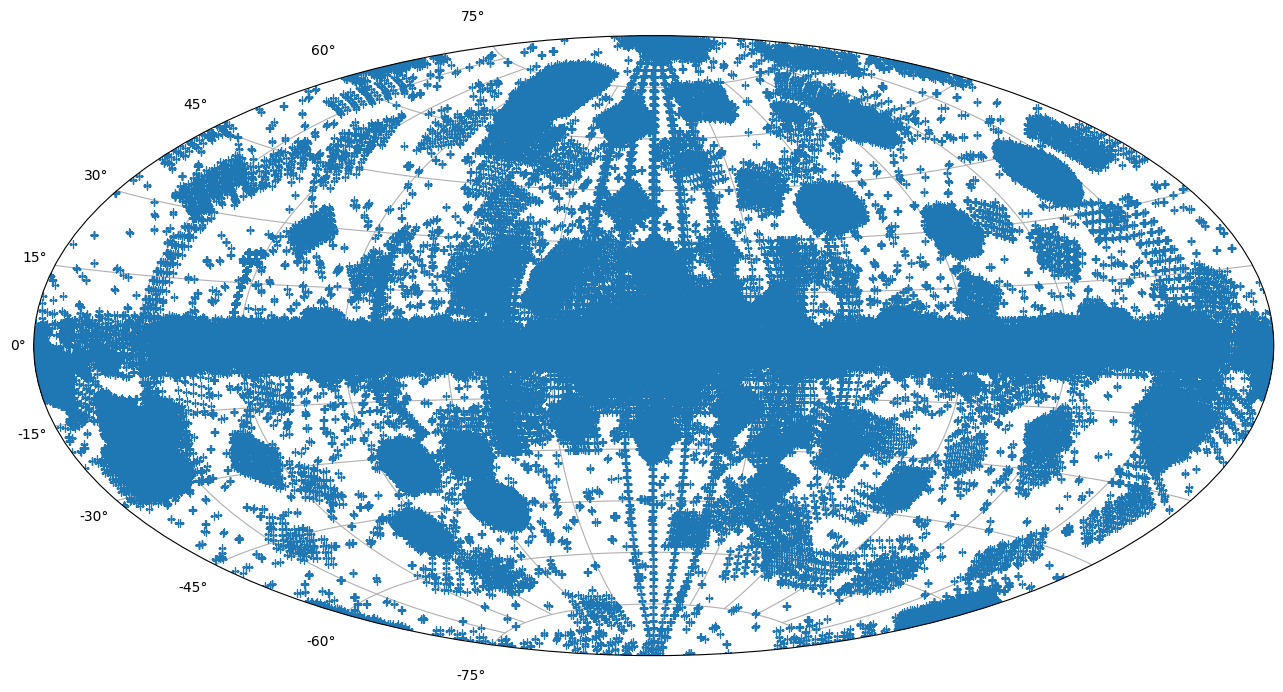

In [ ]:
# plotting the coordinates
plt.figure(figsize=(16,10))
plt.subplot(projection='aitoff')
plt.plot(np.deg2rad(lon_sc),np.deg2rad(lat_sc),'+')
plt.grid()

In [6]:
# Now we want to see which of the pointings are in the area where the object we want to study is located.
# We set the fov of SPI equal to 16
fov_threshold = 16.

# We also need to calculate the angular distance of each pointing to the object. We do this using:
# we need to calculate the angular distance of each pointing to the Crab, which
# can be done by the following functions

def GreatCircle(l1,b1,l2,b2,deg=True):

    if deg == True:
        l1,b1,l2,b2 = np.deg2rad(l1),np.deg2rad(b1),np.deg2rad(l2),np.deg2rad(b2)

    return np.sin(b1)*np.sin(b2) + np.cos(b1)*np.cos(b2)*np.cos(l1-l2)



def angular_distance(l1,b1,l2,b2,deg=True):
    """
    Calculate angular distance on a sphere from longitude/latitude pairs to other using Great circles
    """
    gc = GreatCircle(l1,b1,l2,b2,deg=deg)

    if gc.size == 1:
        if gc > 1:
            gc = 1.
    else:
        gc[np.where(gc > 1)] = 1.

    return np.rad2deg(np.arccos(gc))

In [7]:
# Now to find which pointing see Jupiter we nee to find the position of Jupiter in the requested time period.
# We get the coordinates from:
obj = Horizons(id='5',id_type='majorbody',
               location='500@-198',
               epochs={'start':'2002-10-18',
                       'stop':'2023-12-31',
                       'step':'6h'})

In [8]:
jupiter_eph = obj.ephemerides()
jupiter_eph_df = jupiter_eph.to_pandas()# Converting the data obtained above to a pandas database
jupiter_eph_df

,targetname,datetime_str,datetime_jd,solar_presence,flags,RA,DEC,RA_app,DEC_app,RA_rate,...,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
0,Jupiter Barycenter (5),2002-Oct-18 00:00,2452565.50,,,137.27188,16.91116,137.27012,16.91179,18.68949,...,<NA>,<NA>,<NA>,<NA>,<NA>,108.4643,<NA>,10.2035,129.5536,0.5146
1,Jupiter Barycenter (5),2002-Oct-18 06:00,2452565.75,,,137.30459,16.90143,137.30280,16.90199,18.86299,...,<NA>,<NA>,<NA>,<NA>,<NA>,108.4846,<NA>,10.2161,129.5801,0.5147
2,Jupiter Barycenter (5),2002-Oct-18 12:00,2452566.00,,,137.33758,16.89212,137.33576,16.89263,19.00977,...,<NA>,<NA>,<NA>,<NA>,<NA>,108.5048,<NA>,10.2288,129.6066,0.5151
3,Jupiter Barycenter (5),2002-Oct-18 18:00,2452566.25,,,137.37082,16.88320,137.36897,16.88366,19.15180,...,<NA>,<NA>,<NA>,<NA>,<NA>,108.5251,<NA>,10.2417,129.6332,0.5157
4,Jupiter Barycenter (5),2002-Oct-19 00:00,2452566.50,,,137.40431,16.87468,137.40243,16.87509,19.30801,...,<NA>,<NA>,<NA>,<NA>,<NA>,108.5453,<NA>,10.2546,129.6599,0.5166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30972,Jupiter Barycenter (5),2023-Dec-30 00:00,2460308.50,,,33.36533,12.13503,33.36797,12.13622,-0.96268,...,<NA>,<NA>,<NA>,<NA>,<NA>,30.7421,<NA>,10.0718,40.2809,-1.1416
30973,Jupiter Barycenter (5),2023-Dec-30 06:00,2460308.75,,,33.36383,12.13288,33.36644,12.13391,-0.79978,...,<NA>,<NA>,<NA>,<NA>,<NA>,30.7644,<NA>,10.0966,40.2912,-1.1422
30974,Jupiter Barycenter (5),2023-Dec-30 12:00,2460309.00,,,33.36260,12.13199,33.36518,12.13291,-0.64499,...,<NA>,<NA>,<NA>,<NA>,<NA>,30.7868,<NA>,10.1206,40.3017,-1.1423
30975,Jupiter Barycenter (5),2023-Dec-30 18:00,2460309.25,,,33.36163,12.13204,33.36419,12.13287,-0.49338,...,<NA>,<NA>,<NA>,<NA>,<NA>,30.8091,<NA>,10.1441,40.3126,-1.1420


In [9]:

#Getting the relevant coordinates and dates for these coordinates for Jupiter in the requested time span

gl_jupiter = jupiter_eph_df['GlxLon'].values # galactic longtitude
gl_jupiter[gl_jupiter>180] -= 360
gb_jupiter = jupiter_eph_df['GlxLat'].values # galactic latitude
jd_jupiter = jupiter_eph_df['datetime_jd'].values # dates and time for the position
ra_jupiter = jupiter_eph_df['RA'].values # right ascension
dec_jupiter = jupiter_eph_df['DEC'].values # declination

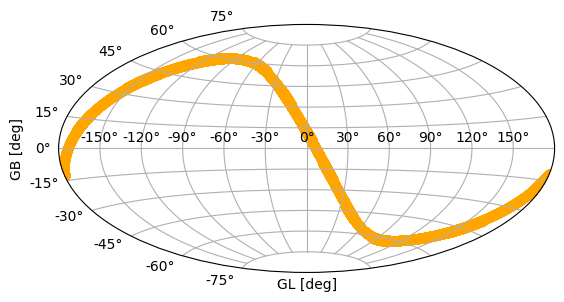

In [10]:
# Plotting the coordinates

plt.subplot(projection='aitoff')
plt.scatter(np.deg2rad(gl_jupiter),np.deg2rad(gb_jupiter),marker='o', c='orange')
plt.xlabel('GL [deg]')
plt.ylabel('GB [deg]')
plt.grid()

In [11]:
# creating a Time object to convert times easily
times_jupiter = Time(jd_jupiter,format='jd')

# converting to MJD:
times_jupiter_mjd = times_jupiter.mjd

# converting to IJD
times_jupiter_ijd = times_jupiter_mjd - 51544
print(times_jupiter_ijd)



[1021.   1021.25 1021.5  ... 8764.5  8764.75 8765.  ]


In [12]:
# getting scw times:
tstart_scw = scw[1].data['TStart']
tend_scw = scw[1].data['TEnd']

n_scw = len(tstart_scw)


valid_times = np.where((tstart_scw >= times_jupiter_ijd.min()) & (tstart_scw <= times_jupiter_ijd.max()))

# Perform linear interpolation
interp_longitude = interp1d(times_jupiter_ijd, gl_jupiter, kind='linear')
interp_latitude = interp1d(times_jupiter_ijd, gb_jupiter, kind='linear')

# Interpolate Jupiter positions for each INTEGRAL observation timestamp
interp_gl = interp_longitude(tstart_scw[valid_times])
interp_gb = interp_latitude(tstart_scw[valid_times])

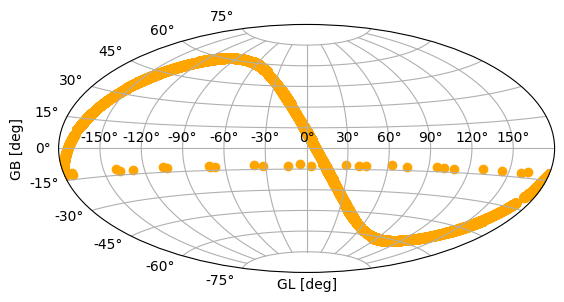

In [13]:
# Plotting the positions

plt.subplot(projection='aitoff')
plt.scatter(np.deg2rad(interp_gl),np.deg2rad(interp_gb),marker='o', c='orange')
plt.xlabel('GL [deg]')
plt.ylabel('GB [deg]')
plt.grid()

In [16]:

jupiter_cross_idx = []

# length of scw file (number of observations)
n_scw = len(tstart_scw)

# length of calculated jupiter positions
n_jupiter = len(interp_gb)

print(n_jupiter)

for i in tqdm(range(n_jupiter)):
         if angular_distance(lon_sc[i],lat_sc[i], interp_gl[i], interp_gb[i]) <= fov_threshold:
                jupiter_cross_idx.append(i)

len(jupiter_cross_idx)

194801


  0%|          | 0/194801 [00:00<?, ?it/s]

5331

In [17]:
def filter_pointings_for_jupiter(scw_file, jupiter_positions, threshold, new_filename, overwrite=True):
    f = fits.open(scw_file)
    cs_f = []
    for col_name in f[1].columns.names:
        c_tmp = fits.Column(name=col_name,
                            array=f[1].data[col_name][jupiter_cross_idx],
                            format=f[1].columns[col_name].format,
                            unit=f[1].columns[col_name].unit)
        cs_f.append(c_tmp)
    # Write filtered pointings to a new file
    t_f = fits.BinTableHDU.from_columns(cs_f)
    t_f.writeto(new_filename, overwrite=overwrite)

    f.close()


In [18]:
filter_pointings_for_jupiter(data_path+scw_file,jupiter_cross_idx,16,data_path+'scw_Jupiter_obs.fits')

In [19]:
# now reading the just-created file in again to see what is the result
scw_Jupiter = fits.open(data_path+'scw_Jupiter_obs.fits')

In [20]:
ra_sc_new = scw_Jupiter[1].data['RA_SCX']
dec_sc_new = scw_Jupiter[1].data['DEC_SCX']

coords_sc_new = SkyCoord(ra=ra_sc_new,dec=dec_sc_new,unit='deg')

lon_sc_new = coords_sc_new.galactic.l.value
lon_sc_new[lon_sc_new > 180] -= 360
lat_sc_new = coords_sc_new.galactic.b.value

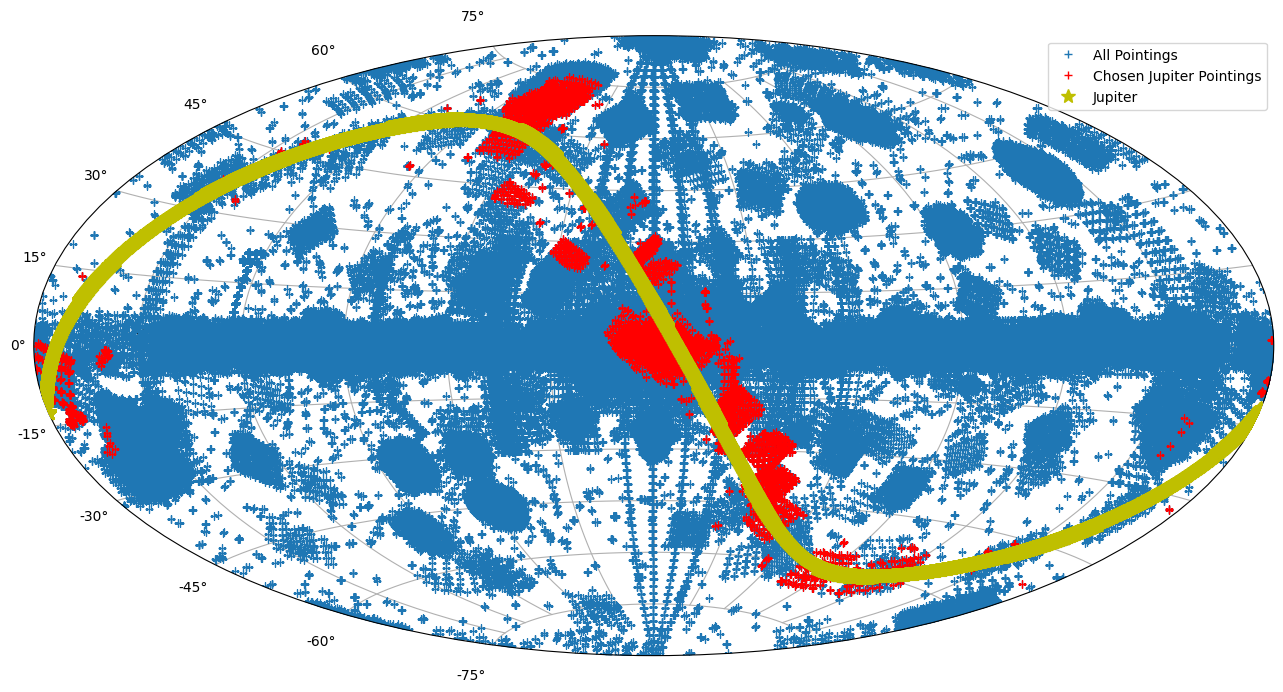

In [21]:
plt.figure(figsize=(16, 10))
plt.subplot(projection='aitoff')

# Plot all pointings
plt.plot(np.deg2rad(lon_sc), np.deg2rad(lat_sc), '+', label='All Pointings')

# Plot chosen pointings coinciding with Jupiter
plt.plot(np.deg2rad(lon_sc_new), np.deg2rad(lat_sc_new), 'r+', label='Chosen Jupiter Pointings')

# Plot Jupiter position (for reference)
plt.plot(np.deg2rad(gl_jupiter), np.deg2rad(gb_jupiter), 'y*', label='Jupiter', zorder=100, markersize=10)
plt.legend(loc=1)
plt.grid()

plt.show()

In [22]:
# Now that we have the pointings that can see Jupiter we will need to consider that Jupiter might be very weak,
# so that we will try to avoid bright sources; Thus we will remove the pointings near the galactic center and the anti-galactic center.
#The anti-galactic center is the crab nebula so we need to find where it is and remove the pointings that are within 30 deg of the Crab.
# The same will happen for the galactic-center.

l_Crab, b_Crab = 184.5574843227357-360, -05.7843392171240 #position of the crab.

scw_filtered = fits.open(data_path+"scw_Jupiter_obs.fits")
scw_filtered.info()

# looking into the pointing distribution:
ra_sc_f = scw_filtered[1].data['RA_SCX']
dec_sc_f = scw_filtered[1].data['DEC_SCX']
# creating coordinate objects for each of the observations
coords_sc_f = SkyCoord(ra=ra_sc_f,dec=dec_sc_f,unit='deg')

# converting the coordinates from ra/dec to Galactic longitude/latitude:
lon_sc_f = coords_sc_f.galactic.l.value
# converting from 0..360 to -180..180
lon_sc_f[lon_sc_f > 180] -= 360
lat_sc_f = coords_sc_f.galactic.b.value
revs_f = scw_filtered[1].data['OrbitRevFrac']
revs_unit_f = scw_filtered[1].columns['OrbitRevFrac'].unit


crab_dist = angular_distance(l_Crab,b_Crab,lon_sc_f,lat_sc_f) #all crab angular distances.
print(crab_dist)

Filename: ./scw_Jupiter_obs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     76   5331R x 26C   [12A, 1I, 1I, 1I, 1I, 20A, 20A, 4I, 4I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 4D, 1D]   
[57.00532941 56.97678496 56.97479811 ... 69.87919348 27.7051645
 27.66756574]


Text(0, 0.5, 'Angular distance to Crab [deg]')

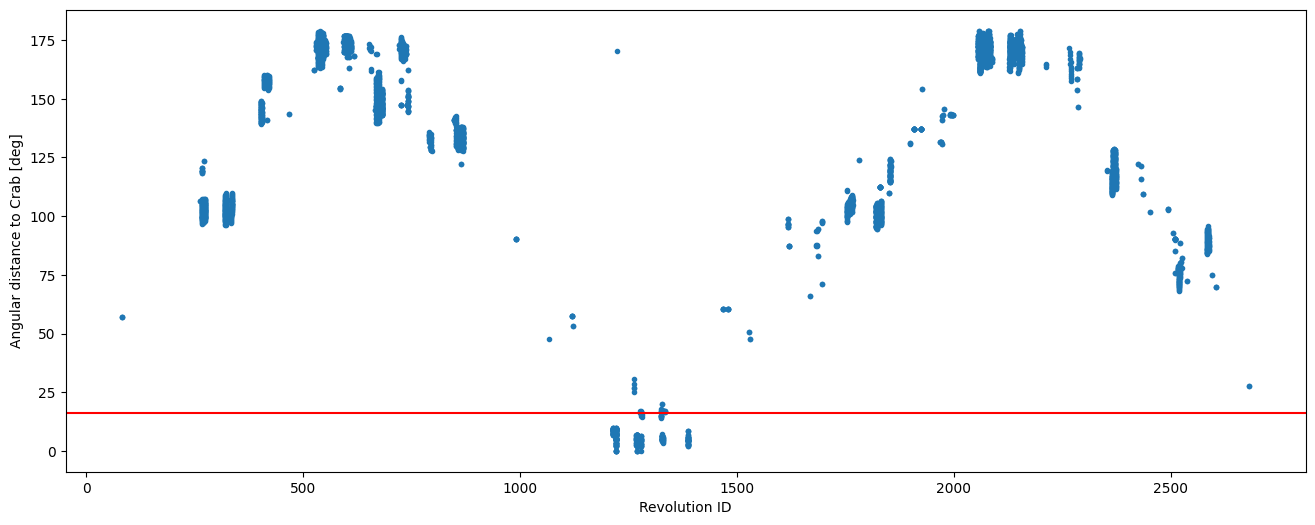

In [23]:
plt.figure(figsize=(16,6))
plt.plot(revs_f,crab_dist,'.')
plt.axhline(fov_threshold,linestyle='-',color='red')
plt.xlabel('Revolution ID')
plt.ylabel('Angular distance to Crab [deg]')

In [24]:
crab_obs_idx = np.where(crab_dist > 30)[0]

def filter_scw(scw_file,filter_idx,new_filename,overwrite=True):

    f = fits.open(scw_file)

    used_columns = []
    for i in range(len(f[1].columns)):
        used_columns.append(f[1].columns[i].name)

    cs_f = []
    for i in range(len(used_columns)):

        c_tmp = fits.Column(name=used_columns[i],
                            array=f[1].data[used_columns[i]][filter_idx],
                            format=f[1].columns[used_columns[i]].format,
                            unit=f[1].columns[used_columns[i]].unit)

        cs_f.append(c_tmp)

    t_f = fits.BinTableHDU.from_columns(cs_f)
    t_f.writeto(new_filename,overwrite=overwrite)

    f.close()


In [25]:
filter_scw(data_path+"scw_Jupiter_obs.fits",crab_obs_idx,data_path+'scw_Jupiter_obs_minusCrab.fits')

In [26]:
swc_minusC =fits.open(data_path+'scw_Jupiter_obs_minusCrab.fits')


ra_sc_mC = swc_minusC[1].data['RA_SCX']
dec_sc_mC = swc_minusC[1].data['DEC_SCX']

coords_sc_mC = SkyCoord(ra=ra_sc_mC,dec=dec_sc_mC,unit='deg')

lon_sc_mC = coords_sc_mC.galactic.l.value
lon_sc_mC[lon_sc_mC > 180] -= 360
lat_sc_mC = coords_sc_mC.galactic.b.value

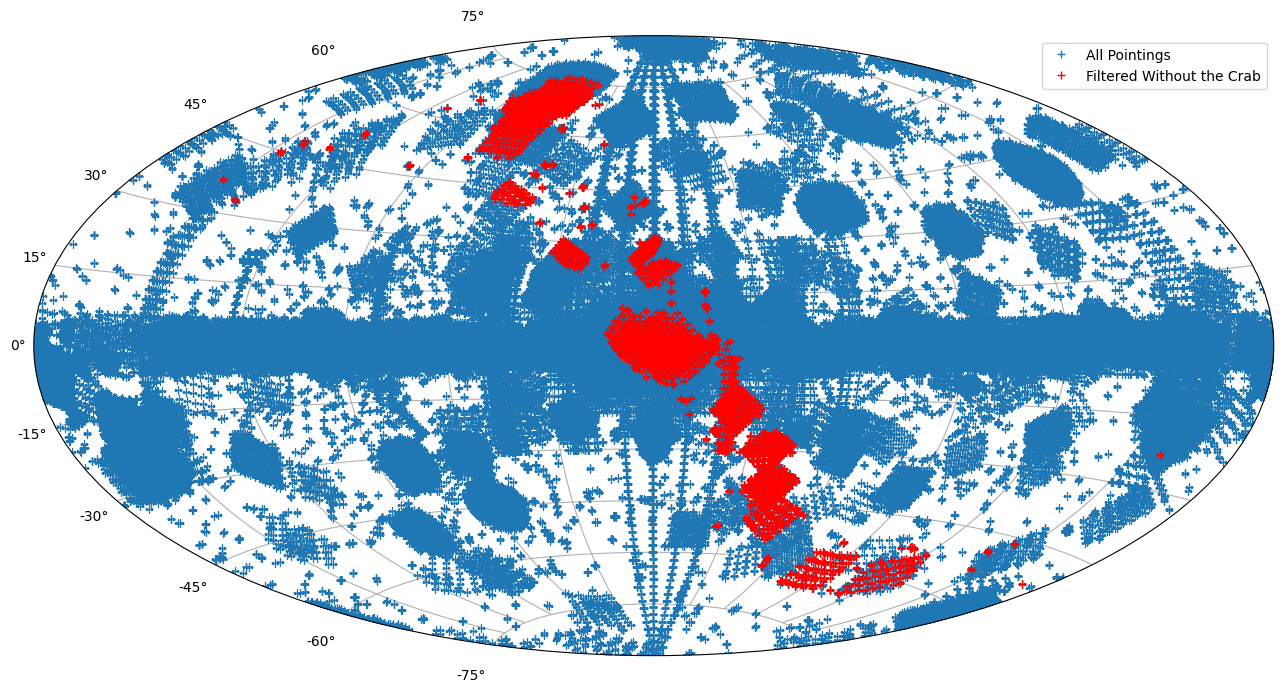

In [28]:
plt.figure(figsize=(16,10))
plt.subplot(projection='aitoff')
plt.plot(np.deg2rad(lon_sc),np.deg2rad(lat_sc),'+',label='All Pointings')
plt.plot(np.deg2rad(lon_sc_mC),np.deg2rad(lat_sc_mC),'r+',label='Filtered Without the Crab')
plt.legend(loc=1)
plt.grid()

In [33]:
l_center, b_center = 0, 0 #position of the crab.

scw_filtered_center = fits.open(data_path+"scw_Jupiter_obs_minusCrab.fits")
scw_filtered_center.info()

# looking into the pointing distribution:
ra_sc_f_c = scw_filtered_center[1].data['RA_SCX']
dec_sc_f_c = scw_filtered_center[1].data['DEC_SCX']
# creating coordinate objects for each of the observations
coords_sc_f_c = SkyCoord(ra=ra_sc_f_c,dec=dec_sc_f_c,unit='deg')

# converting the coordinates from ra/dec to Galactic longitude/latitude:
lon_sc_f_c = coords_sc_f_c.galactic.l.value
# converting from 0..360 to -180..180
lon_sc_f_c[lon_sc_f_c > 180] -= 360
lat_sc_f_c = coords_sc_f_c.galactic.b.value
revs_f_c = scw_filtered_center[1].data['OrbitRevFrac']
revs_unit_f_c = scw_filtered_center[1].columns['OrbitRevFrac'].unit


center_dist = angular_distance(l_center,b_center,lon_sc_f_c,lat_sc_f_c) #all galactic center angular distances.
print(center_dist)

Filename: ./scw_Jupiter_obs_minusCrab.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     76   4942R x 26C   [12A, 1I, 1I, 1I, 1I, 20A, 20A, 4I, 4I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 4D, 1D]   
[126.03354804 126.15942061 126.16124911 ... 107.43450124 107.38862683
 107.38857782]


In [34]:
center_idx = np.where(center_dist > 30)[0]

def filter_scw(scw_file,filter_idx,new_filename,overwrite=True):

    f = fits.open(scw_file)

    used_columns = []
    for i in range(len(f[1].columns)):
        used_columns.append(f[1].columns[i].name)

    cs_f = []
    for i in range(len(used_columns)):

        c_tmp = fits.Column(name=used_columns[i],
                            array=f[1].data[used_columns[i]][filter_idx],
                            format=f[1].columns[used_columns[i]].format,
                            unit=f[1].columns[used_columns[i]].unit)

        cs_f.append(c_tmp)

    t_f = fits.BinTableHDU.from_columns(cs_f)
    t_f.writeto(new_filename,overwrite=overwrite)

    f.close()


In [37]:
filter_scw(data_path+"scw_Jupiter_obs_minusCrab.fits",center_idx,data_path+'scw_Jupiter_obs_final.fits')

swc_final =fits.open(data_path+'scw_Jupiter_obs_final.fits')


ra_sc_final = swc_final[1].data['RA_SCX']
dec_sc_final = swc_final[1].data['DEC_SCX']

coords_sc_final = SkyCoord(ra=ra_sc_final,dec=dec_sc_final,unit='deg')

lon_sc_final = coords_sc_final.galactic.l.value
lon_sc_final[lon_sc_final > 180] -= 360
lat_sc_final = coords_sc_final.galactic.b.value

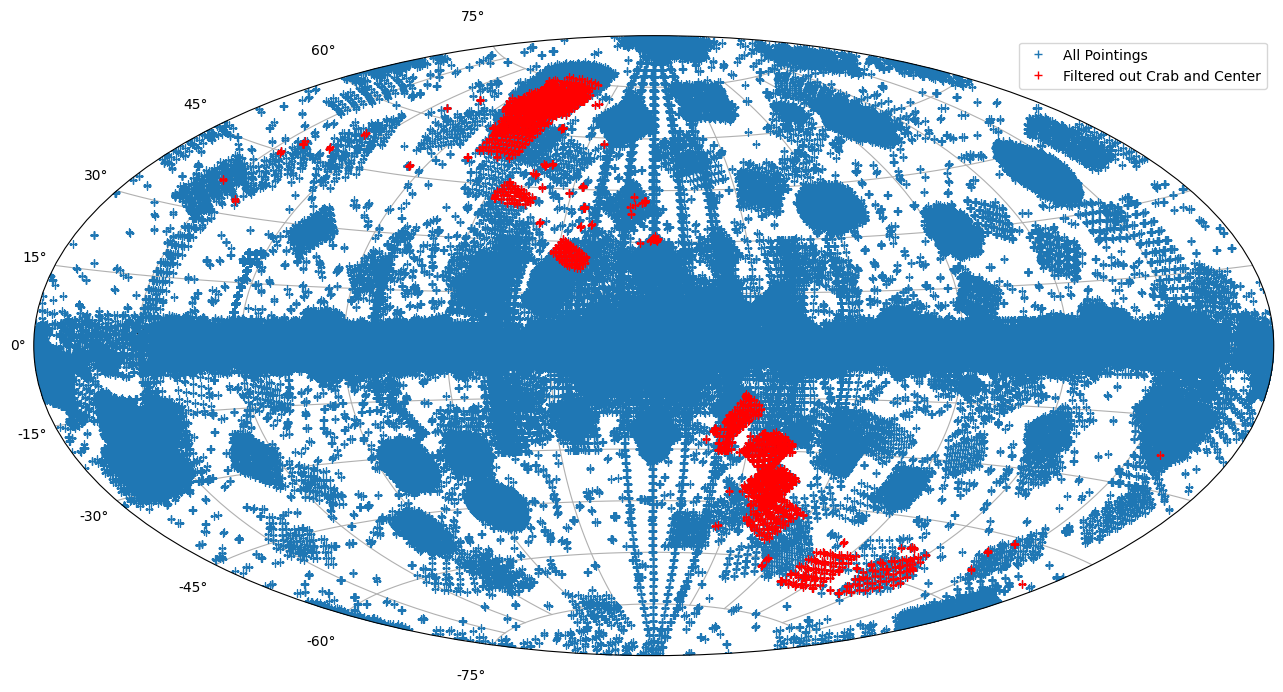

In [38]:
plt.figure(figsize=(16,10))
plt.subplot(projection='aitoff')
plt.plot(np.deg2rad(lon_sc),np.deg2rad(lat_sc),'+',label='All Pointings')
plt.plot(np.deg2rad(lon_sc_final),np.deg2rad(lat_sc_final),'r+',label='Filtered out Crab and Center')
plt.legend(loc=1)
plt.grid()

In [40]:
center_idx = np.where(center_dist > 40)[0]

filter_scw(data_path+"scw_Jupiter_obs_minusCrab.fits",center_idx,data_path+'scw_Jupiter_obs_final40.fits')

swc_final40 =fits.open(data_path+'scw_Jupiter_obs_final40.fits')


ra_sc_final40 = swc_final40[1].data['RA_SCX']
dec_sc_final40 = swc_final40[1].data['DEC_SCX']

coords_sc_final40 = SkyCoord(ra=ra_sc_final40,dec=dec_sc_final40,unit='deg')

lon_sc_final40 = coords_sc_final40.galactic.l.value
lon_sc_final40[lon_sc_final40 > 180] -= 360
lat_sc_final40 = coords_sc_final40.galactic.b.value

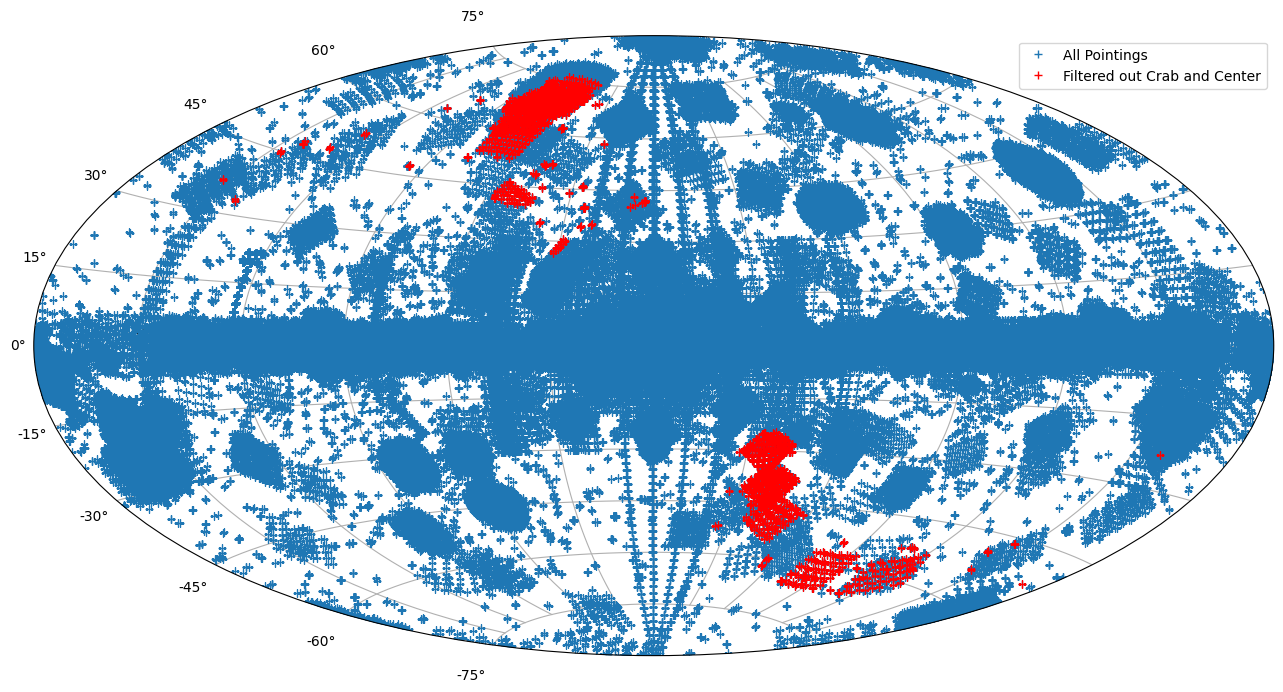

In [41]:
plt.figure(figsize=(16,10))
plt.subplot(projection='aitoff')
plt.plot(np.deg2rad(lon_sc),np.deg2rad(lat_sc),'+',label='All Pointings')
plt.plot(np.deg2rad(lon_sc_final40),np.deg2rad(lat_sc_final40),'r+',label='Filtered out Crab and Center')
plt.legend(loc=1)
plt.grid()